# Deep Learning
<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marcinsawinski/UEP_KIE_DL_CODE2024/blob/main/dl02_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Quickstart tutorial
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.

## Working with data

PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.

In [87]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO (full list here). In this tutorial, we use the FashionMNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [88]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [89]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Creating Models

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the accelerator such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

In [90]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the Model Parameters

To train a model, we need a loss function and an optimizer.

In [91]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [92]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning.

In [93]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [94]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.321805  [   64/60000]
loss: 2.303021  [ 6464/60000]
loss: 2.281991  [12864/60000]
loss: 2.265954  [19264/60000]
loss: 2.247685  [25664/60000]
loss: 2.229827  [32064/60000]
loss: 2.237078  [38464/60000]
loss: 2.210865  [44864/60000]
loss: 2.207241  [51264/60000]
loss: 2.163140  [57664/60000]
Test Error: 
 Accuracy: 36.3%, Avg loss: 2.163691 

Epoch 2
-------------------------------
loss: 2.187979  [   64/60000]
loss: 2.171305  [ 6464/60000]
loss: 2.116542  [12864/60000]
loss: 2.124376  [19264/60000]
loss: 2.069546  [25664/60000]
loss: 2.027903  [32064/60000]
loss: 2.054025  [38464/60000]
loss: 1.981510  [44864/60000]
loss: 1.987520  [51264/60000]
loss: 1.907061  [57664/60000]
Test Error: 
 Accuracy: 50.4%, Avg loss: 1.906586 

Epoch 3
-------------------------------
loss: 1.954411  [   64/60000]
loss: 1.916842  [ 6464/60000]
loss: 1.803972  [12864/60000]
loss: 1.831828  [19264/60000]
loss: 1.717695  [25664/60000]
loss: 1.687354  [32064/600

## Saving Models

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [95]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [96]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.

In [97]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


---


# Helpers - just run it, no need to read it.
- Generate 4 simple datasets
- Functions for visualization

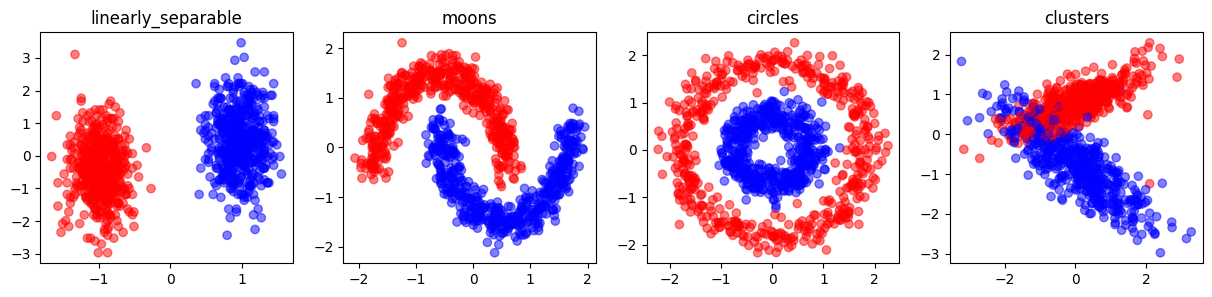

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler

# Constants
N_SAMPLES = 1000
RANDOM_STATE = 1
TEST_SIZE = 0.2
CM_BRIGHT = ListedColormap(["#FF0000", "#0000FF"])
LINEARLY_SEPARABLE_DISTANCE = 5


def make_linearly_separable(n_samples=100, random_state=42):
    """Generates linearly separable data."""
    np.random.seed(random_state)
    class_size = n_samples // 2
    X1 = np.round(np.random.normal(0, 1, (class_size, 2)), 1)
    X2 = np.round(np.random.normal(0, 1, (class_size, 2)), 1) + [9, 1]
    X = np.vstack((X1, X2))
    y = np.hstack((np.zeros(class_size), np.ones(class_size)))
    perm = np.random.permutation(len(X))
    X, y = X[perm], y[perm]
    return X, y


def generate_datasets():
    """Generates datasets including an additional linearly separable dataset."""
    datasets = {
        "linearly_separable": make_linearly_separable(
            n_samples=N_SAMPLES,
            random_state=RANDOM_STATE,
        ),
        "moons": make_moons(noise=0.1, random_state=RANDOM_STATE, n_samples=N_SAMPLES),
        "circles": make_circles(
            noise=0.1, factor=0.4, random_state=RANDOM_STATE, n_samples=N_SAMPLES
        ),
        "clusters": make_classification(
            n_features=2,
            n_redundant=0,
            n_informative=2,
            random_state=RANDOM_STATE,
            n_clusters_per_class=1,
            n_samples=N_SAMPLES,
        ),
    }
    # scale X
    scaled_datasets = {}
    for name, (X, y) in datasets.items():
        X_scaled = StandardScaler().fit_transform(X)
        scaled_datasets[name] = (X_scaled.astype(np.float32), y.astype(np.float32))
    return scaled_datasets


def plot_datasets(datasets):
    """Plots training and test sets for all datasets."""
    _, axs = plt.subplots(1, len(datasets), figsize=(15, 3))

    for i, (name, data) in enumerate(datasets.items()):
        X, y = data
        axs[i].scatter(
            X[:, 0],
            X[:, 1],
            c=y,
            cmap=CM_BRIGHT,
            alpha=0.5,
        )
        axs[i].set_title(name)
    plt.show()


datasets = generate_datasets()
plot_datasets(datasets)

---
# Datasets and dataloaders

In [99]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import ToTensor
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split


# Load dataset
ds = "circles"
X, y = datasets[ds]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# or

# X_train_tensor = torch.from_numpy(X_train)
# y_train_tensor = torch.from_numpy(y_train.reshape(-1, 1))

# X_test_tensor = torch.from_numpy(X_test)
# y_test_tensor = torch.from_numpy(y_test.reshape(-1, 1))

training_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32  # adjust this according to your needs

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---

# Excercise 1: Multilayer Perceptron with Torch


 Your task is to implement a simple **Multi-Layer Perceptron** (MLP) with Pytorch.
1. Split generated datasets to train/test and convert to torch.utils.data.Dataset and  torch.utils.data.DataLoader objects
2. Define model
 - Start with  **1 hidden layer**, later experiment with more hidden layers.
 - Start with `nn.Sigmoid()` activation. for hidden layers. Try `nn.ReLU`, `nn.Tanh`. See: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
 - Training should be implemented with **binary cross-entropy** loss function. Try 2 options:
    - 'loss_fn = nn.BCELoss()' with output layer ending with sigmoid activation
    - 'loss_fn = nn.BCEWithLogitsLoss()' with output layer ending with logits (no activation).
    Compare which works better?
    NOTE. When implementing test loop you apply sigmoid to predictions before gettgin predicted class
        ```
        pred = model(X)
        prob = torch.sigmoid(pred)
        predicted_classes = (prob > 0.5).float()
        ```
3. Define training methods
 - Try various optimizers and learning rates. Start with `torch.optim.SGD` then try `torch.optim.Adam`
 - Try diffrent devcices CUDA/MPS and CPU
    ```
    device = (torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu")
    ```
- Incorporate metrics from `torchmetrics`. Replace manual accuracy calculation with `torchmetrics.Accuracy(task="binary")`. Add F1 Score.

## Put your code below


In [102]:
!pip install torchmetrics

In [103]:
import torchmetrics

In [116]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

class MLP_sigmoid(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16,1),
    )

  def forward(self, x):
    x = self.model(x)
    return torch.sigmoid(x)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    accuracy = Accuracy(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        predicted_classes = (torch.sigmoid(pred) > 0.5).float()
        accuracy.update(predicted_classes, y.int())
        f1.update(predicted_classes, y.int())
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    print(f"Train Accuracy: {accuracy.compute()*100:>0.1f}%")
    print(f"Train F1 Score: {f1.compute()*100:>0.1f}%")

    accuracy.reset()
    f1.reset()

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    accuracy = Accuracy(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            predicted_classes = (pred > 0.5).float()
            accuracy.update(predicted_classes, y.int())
            f1.update(predicted_classes, y.int())

    test_loss /= num_batches

    print(f"Test Error:")
    print(f" Accuracy: {accuracy.compute()*100:>0.1f}%")
    print(f" F1 Score: {f1.compute()*100:>0.1f}%")
    print(f" Avg loss: {test_loss:>8f} \n")

    accuracy.reset()
    f1.reset()

Using cpu device


### BCELoss

In [117]:
model = MLP_sigmoid().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.667277  [   32/  800]
Train Accuracy: 49.6%
Train F1 Score: 66.3%
Test Error:
 Accuracy: 48.5%
 F1 Score: 0.0%
 Avg loss: 0.679423 

Epoch 2
-------------------------------
loss: 0.692518  [   32/  800]
Train Accuracy: 49.6%
Train F1 Score: 66.3%
Test Error:
 Accuracy: 48.5%
 F1 Score: 0.0%
 Avg loss: 0.673256 

Epoch 3
-------------------------------
loss: 0.633280  [   32/  800]
Train Accuracy: 49.6%
Train F1 Score: 66.3%
Test Error:
 Accuracy: 48.5%
 F1 Score: 0.0%
 Avg loss: 0.667833 

Epoch 4
-------------------------------
loss: 0.643214  [   32/  800]
Train Accuracy: 49.6%
Train F1 Score: 66.3%
Test Error:
 Accuracy: 48.5%
 F1 Score: 0.0%
 Avg loss: 0.662856 

Epoch 5
-------------------------------
loss: 0.655655  [   32/  800]
Train Accuracy: 49.6%
Train F1 Score: 66.3%
Test Error:
 Accuracy: 48.5%
 F1 Score: 0.0%
 Avg loss: 0.658208 

Epoch 6
-------------------------------
loss: 0.687676  [   32/  800]
Train Accuracy: 49.6%
Tra

### BCEWithLogitsLoss

In [118]:
class MLP_logits(nn.Module):
    def __init__(self):
        super(MLP_logits, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)

model2 = MLP_logits().to(device)
loss_fn2 = nn.BCEWithLogitsLoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model2, loss_fn2, optimizer2)
    test(test_dataloader, model2, loss_fn2)
print("Done!")

Epoch 1
-------------------------------
loss: 0.698068  [   32/  800]
Train Accuracy: 60.6%
Train F1 Score: 63.7%
Test Error:
 Accuracy: 47.0%
 F1 Score: 0.0%
 Avg loss: 0.682806 

Epoch 2
-------------------------------
loss: 0.681813  [   32/  800]
Train Accuracy: 61.1%
Train F1 Score: 63.1%
Test Error:
 Accuracy: 48.5%
 F1 Score: 0.0%
 Avg loss: 0.678942 

Epoch 3
-------------------------------
loss: 0.650200  [   32/  800]
Train Accuracy: 61.9%
Train F1 Score: 63.5%
Test Error:
 Accuracy: 48.5%
 F1 Score: 0.0%
 Avg loss: 0.675318 

Epoch 4
-------------------------------
loss: 0.680116  [   32/  800]
Train Accuracy: 62.9%
Train F1 Score: 63.3%
Test Error:
 Accuracy: 48.5%
 F1 Score: 0.0%
 Avg loss: 0.671896 

Epoch 5
-------------------------------
loss: 0.667139  [   32/  800]
Train Accuracy: 64.2%
Train F1 Score: 64.2%
Test Error:
 Accuracy: 48.5%
 F1 Score: 0.0%
 Avg loss: 0.668601 

Epoch 6
-------------------------------
loss: 0.678819  [   32/  800]
Train Accuracy: 64.8%
Tra

# More layers!

In [119]:
class MLP_logits(nn.Module):
    def __init__(self):
        super(MLP_logits, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

In [121]:
model3 = MLP_logits().to(device)
loss_fn3 = nn.BCEWithLogitsLoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.05)

import sys
epochs = 20
for t in range(epochs):
    sys.stdout.write(f"Epoch {t+1}\n-------------------------------")
    sys.stdout.flush()
    train(train_dataloader, model3, loss_fn3, optimizer3)
    test(test_dataloader, model3, loss_fn3)
print("Done!")

Epoch 1
-------------------------------loss: 0.710563  [   32/  800]
Train Accuracy: 90.9%
Train F1 Score: 90.3%
Test Error:
 Accuracy: 98.5%
 F1 Score: 98.5%
 Avg loss: 0.036434 

Epoch 2
-------------------------------loss: 0.419070  [   32/  800]
Train Accuracy: 98.4%
Train F1 Score: 98.4%
Test Error:
 Accuracy: 94.5%
 F1 Score: 94.6%
 Avg loss: 0.223406 

Epoch 3
-------------------------------loss: 0.109332  [   32/  800]
Train Accuracy: 97.8%
Train F1 Score: 97.7%
Test Error:
 Accuracy: 97.5%
 F1 Score: 97.5%
 Avg loss: 0.065915 

Epoch 4
-------------------------------loss: 0.135005  [   32/  800]
Train Accuracy: 98.8%
Train F1 Score: 98.7%
Test Error:
 Accuracy: 98.5%
 F1 Score: 98.5%
 Avg loss: 0.021786 

Epoch 5
-------------------------------loss: 0.001763  [   32/  800]
Train Accuracy: 99.5%
Train F1 Score: 99.5%
Test Error:
 Accuracy: 100.0%
 F1 Score: 100.0%
 Avg loss: 0.004379 

Epoch 6
-------------------------------loss: 0.022905  [   32/  800]
Train Accuracy: 99.4%
Tr